In [10]:
from utils import to_class_labels, imshow
import torch
from einops import rearrange
import numpy as np
import math
from pprint import pprint, pformat
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import models
from pathlib import Path
import inspect

In [12]:
CONFIG = type('', (), {})() # object for parameters

CONFIG.model_class = models.OpticalSystem
CONFIG.layers = 1
CONFIG.mlp_layers = 2
CONFIG.batch_size = 764//5
CONFIG.max_passes_through_dataset = 20
CONFIG.test_batch_size = 64

# свойства входных данных
CONFIG.dataset_name = 'quickdraw'
CONFIG.classes = 16
CONFIG.image_size = 28
CONFIG.train_class_instances = 8000
CONFIG.test_class_instances = 100
CONFIG.train_data_path = './assets/quickdraw16_train.npy'
CONFIG.test_data_path = './assets/quickdraw16_test.npy'

# свойства модели оптической системы
CONFIG.kernel_size_pixels = 28
CONFIG.tile_size_scale_factor = 2
CONFIG.resolution_scale_factor = 2 
CONFIG.class_slots = 16
CONFIG.wavelength = 532e-9
# CONFIG.refractive_index = 1.5090
CONFIG.propagation_distance = 300
CONFIG.metric = 1e-3
CONFIG.pixel_size_meters = 36e-6

CONFIG.name_id = f"{CONFIG.model_class.__name__}_{CONFIG.dataset_name}_{CONFIG.layers}_{CONFIG.mlp_layers}_{CONFIG.classes}_{CONFIG.max_passes_through_dataset}_{CONFIG.kernel_size_pixels}" + \
                 f"_{CONFIG.resolution_scale_factor}_{CONFIG.tile_size_scale_factor}_{CONFIG.propagation_distance}_{CONFIG.wavelength}_{CONFIG.metric}_{CONFIG.pixel_size_meters}"
CONFIG.experiment_dir = Path(f'./experiments/{CONFIG.name_id}/')
CONFIG.experiment_dir.mkdir(parents=True, exist_ok=True)
CONFIG.model_path = CONFIG.experiment_dir / f"{CONFIG.name_id}.pt"
CONFIG.loss_plot_path = CONFIG.experiment_dir / f"{CONFIG.name_id}_loss.png"

def init_from_config(config):
    init_arg_names = list(inspect.signature(CONFIG.model_class).parameters.keys())
    return CONFIG.model_class(**{k:CONFIG.__dict__[k] for k in init_arg_names})

pprint(CONFIG.__dict__)

{'batch_size': 152,
 'class_slots': 16,
 'classes': 16,
 'dataset_name': 'quickdraw',
 'experiment_dir': PosixPath('experiments/OpticalSystem_quickdraw_1_2_16_20_28_2_2_300_5.32e-07_0.001_3.6e-05'),
 'image_size': 28,
 'kernel_size_pixels': 28,
 'layers': 1,
 'loss_plot_path': PosixPath('experiments/OpticalSystem_quickdraw_1_2_16_20_28_2_2_300_5.32e-07_0.001_3.6e-05/OpticalSystem_quickdraw_1_2_16_20_28_2_2_300_5.32e-07_0.001_3.6e-05_loss.png'),
 'max_passes_through_dataset': 20,
 'metric': 0.001,
 'mlp_layers': 2,
 'model_class': <class 'models.OpticalSystem'>,
 'model_path': PosixPath('experiments/OpticalSystem_quickdraw_1_2_16_20_28_2_2_300_5.32e-07_0.001_3.6e-05/OpticalSystem_quickdraw_1_2_16_20_28_2_2_300_5.32e-07_0.001_3.6e-05.pt'),
 'name_id': 'OpticalSystem_quickdraw_1_2_16_20_28_2_2_300_5.32e-07_0.001_3.6e-05',
 'pixel_size_meters': 3.6e-05,
 'propagation_distance': 300,
 'resolution_scale_factor': 2,
 'test_batch_size': 64,
 'test_class_instances': 100,
 'test_data_path': './a

In [15]:
train_data = torch.tensor(np.load(CONFIG.train_data_path), dtype=torch.float32)
test_data = torch.tensor(np.load(CONFIG.test_data_path), dtype=torch.float32)
train_data = rearrange(train_data, "b (h w) -> b 1 h w", h=CONFIG.image_size, w=CONFIG.image_size)
test_data = rearrange(test_data, "b (h w) -> b 1 h w", h=CONFIG.image_size, w=CONFIG.image_size)
train_data.shape, test_data.shape

train_targets = torch.eye(CONFIG.classes).repeat_interleave(repeats=CONFIG.train_class_instances, dim=0)
test_targets = torch.eye(CONFIG.classes).repeat_interleave(repeats=CONFIG.test_class_instances, dim=0)

train_labels = torch.repeat_interleave(torch.arange(CONFIG.classes), CONFIG.train_class_instances)
test_labels = torch.repeat_interleave(torch.arange(CONFIG.classes), CONFIG.test_class_instances)

train_targets.shape, test_targets.shape

(torch.Size([128000, 16]), torch.Size([1600, 16]))

In [16]:
inputs = test_data
targets = test_targets

In [17]:
model = init_from_config(CONFIG)
# comment to train from scratch
model.load_state_dict(torch.load(CONFIG.model_path))
model.eval()
model.cuda();

### amplitude noise

In [18]:
import types

def to_class_labels(softmax_distibutions):
    return torch.argmax(softmax_distibutions, dim=1).cpu()

def test(inputs, targets, noise_percent=0.1):
    def opt_conv(self, inputs, heights):
        result = self.propagation(field=inputs, propagation_distance=self.propagation_distance)
        result = result * heights 
        result.real += torch.randn_like(result.real)*(result.real.abs().max()*noise_percent)
        result = self.propagation(field=result, propagation_distance=self.propagation_distance)
        amplitude = torch.sqrt(result.real**2 + result.imag**2)
        return amplitude

    model.opt_conv = types.MethodType(opt_conv, model) 
    
    predicted = []
    batch_start = 0
    while batch_start < test_data.shape[0]:
        batch_end = min(batch_start + CONFIG.test_batch_size, test_data.shape[0])
        batch_input = inputs[batch_start:batch_end].cuda() 
        with torch.inference_mode():
            batch_output, _ = model(batch_input)
        predicted.append(batch_output.cpu())
        batch_start = batch_end
    
    predicted = torch.concat(predicted)
    
    test_acc = accuracy_score(to_class_labels(targets), to_class_labels(predicted))
    return test_acc

In [19]:
x = np.arange(0, 1.0, 0.01)
y_amp = []
for p in x:
    y_amp.append(np.mean([test(inputs, targets, noise_percent=p) for _ in range(5)]))

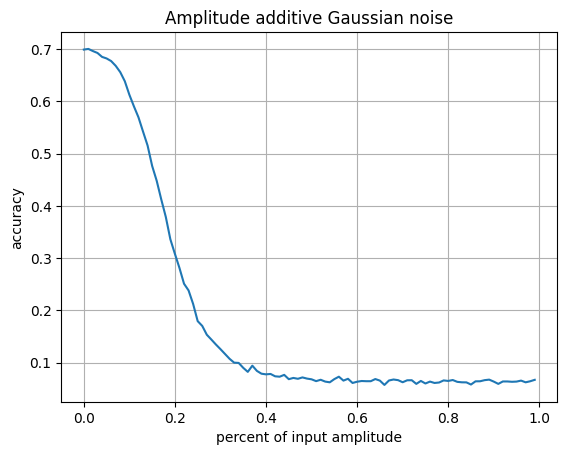

In [20]:
plt.plot(x,y_amp)
plt.xlabel("percent of input amplitude")
plt.ylabel("accuracy")
plt.title("Amplitude additive Gaussian noise")
plt.grid()

### phase noise

In [21]:
import types

def to_class_labels(softmax_distibutions):
    return torch.argmax(softmax_distibutions, dim=1).cpu()

def test(inputs, targets, noise_percent=0.1):
    def opt_conv(self, inputs, heights):
        result = self.propagation(field=inputs, propagation_distance=self.propagation_distance)
        result = result * heights 
        result.imag += torch.randn_like(result.imag)*(result.imag.abs().max()*noise_percent)
        result = self.propagation(field=result, propagation_distance=self.propagation_distance)
        amplitude = torch.sqrt(result.real**2 + result.imag**2)
        return amplitude

    model.opt_conv = types.MethodType(opt_conv, model) 
    
    predicted = []
    batch_start = 0
    while batch_start < test_data.shape[0]:
        batch_end = min(batch_start + CONFIG.test_batch_size, test_data.shape[0])
        batch_input = inputs[batch_start:batch_end].cuda() 
        with torch.inference_mode():
            batch_output, _ = model(batch_input)
        predicted.append(batch_output.cpu())
        batch_start = batch_end
    
    predicted = torch.concat(predicted)
    
    test_acc = accuracy_score(to_class_labels(targets), to_class_labels(predicted))
    return test_acc

In [22]:
x = np.arange(0, 1.0, 0.01)
y_phase = []
for p in x:
    y_phase.append(np.mean([test(inputs, targets, noise_percent=p) for _ in range(5)]))

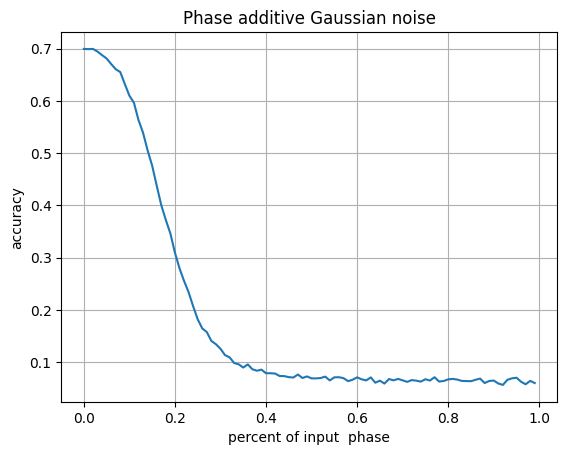

In [23]:
plt.plot(x,y_phase)
plt.xlabel("percent of input  phase")
plt.ylabel("accuracy")
plt.title("Phase additive Gaussian noise")
plt.grid()

### both noise

In [24]:
import types

def to_class_labels(softmax_distibutions):
    return torch.argmax(softmax_distibutions, dim=1).cpu()

def test(inputs, targets, noise_percent=0.1):
    def opt_conv(self, inputs, heights):
        result = self.propagation(field=inputs, propagation_distance=self.propagation_distance)
        result = result * heights 
        result.real += torch.randn_like(result.real)*(result.real.abs().max()*noise_percent)
        result.imag += torch.randn_like(result.imag)*(result.imag.abs().max()*noise_percent)
        result = self.propagation(field=result, propagation_distance=self.propagation_distance)
        amplitude = torch.sqrt(result.real**2 + result.imag**2)
        return amplitude

    model.opt_conv = types.MethodType(opt_conv, model) 
    
    predicted = []
    batch_start = 0
    while batch_start < test_data.shape[0]:
        batch_end = min(batch_start + CONFIG.test_batch_size, test_data.shape[0])
        batch_input = inputs[batch_start:batch_end].cuda() 
        with torch.inference_mode():
            batch_output, _ = model(batch_input)
        predicted.append(batch_output.cpu())
        batch_start = batch_end
    
    predicted = torch.concat(predicted)
    
    test_acc = accuracy_score(to_class_labels(targets), to_class_labels(predicted))
    return test_acc

In [25]:
x = np.arange(0, 1.0, 0.01)
y_ampphase = []
for p in x:
    y_ampphase.append(np.mean([test(inputs, targets, noise_percent=p) for _ in range(5)]))

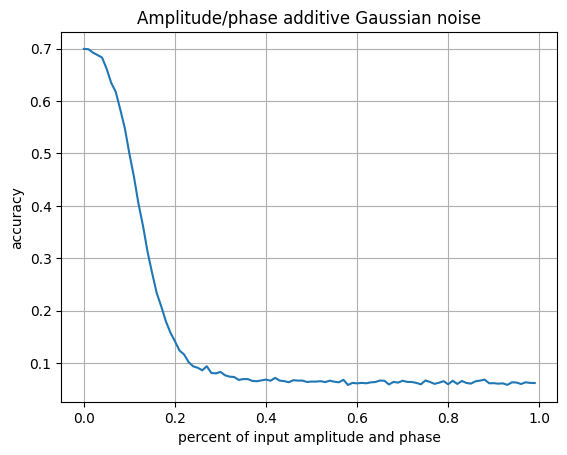

In [26]:
plt.plot(x,y_ampphase)
plt.xlabel("percent of input amplitude and phase")
plt.ylabel("accuracy")
plt.title("Amplitude/phase additive Gaussian noise")
plt.grid()

#### one layer at a time 

In [27]:
import types
from utils import pad_zeros, unpad_zeros
from torchvision.transforms.functional import resize, InterpolationMode
from einops import rearrange

def to_class_labels(softmax_distibutions):
    return torch.argmax(softmax_distibutions, dim=1).cpu()

def test(inputs, targets, noise_percent=0.1, noise_layer_id=0):
    def forward(self, image):
        image = resize(
            image, 
            size=(image.shape[-2]*self.resolution_scale_factor,
                  image.shape[-1]*self.resolution_scale_factor),
            interpolation=InterpolationMode.NEAREST
        )
        # debug_out.append(image)
        # 2
        image = pad_zeros(
            image, 
            size = (self.phase_mask_size, 
                    self.phase_mask_size),
        )
        # 3      
        x = image 
        for i, plate_heights in enumerate(self.height_maps):  
            x = self.opt_conv(x, plate_heights, i)
        convolved = x
        # 4
        grid_to_depth = rearrange(
            convolved,
            "b 1 (m ht) (n wt) -> b (m n) ht wt",
            ht = self.tile_size*self.resolution_scale_factor,
            wt = self.tile_size*self.resolution_scale_factor,
            m = self.tiles_per_dim,
            n = self.tiles_per_dim
        )
        # 5
        grid_to_depth = unpad_zeros(grid_to_depth, 
                                    (self.kernel_size_pixels*self.resolution_scale_factor,  
                                     self.kernel_size_pixels*self.resolution_scale_factor))
        max_pool = torch.nn.functional.max_pool2d(
            grid_to_depth,
            kernel_size = self.kernel_size_pixels*self.resolution_scale_factor
        )         
        max_pool = rearrange(max_pool, "b class_slots 1 1 -> b class_slots", class_slots=self.class_slots)
        max_pool /= max_pool.max(dim=1, keepdims=True).values
        # 6
        # CrossEntropy already has logsoftmax
        # softmax = torch.nn.functional.log_softmax(max_pool, dim=1)
        return max_pool, convolved

    def opt_conv(self, inputs, heights, i):
        result = self.propagation(field=inputs, propagation_distance=self.propagation_distance)
        result = result * heights
        if i == noise_layer_id:
            result.real += torch.randn_like(result.real)*(result.real.max()*noise_percent)
            result.imag += torch.randn_like(result.imag)*(result.imag.max()*noise_percent)
        result = self.propagation(field=result, propagation_distance=self.propagation_distance)
        amplitude = torch.sqrt(result.real**2 + result.imag**2)
        return amplitude

    model.forward = types.MethodType(forward, model)
    model.opt_conv = types.MethodType(opt_conv, model) 
    
    predicted = []
    batch_start = 0
    while batch_start < test_data.shape[0]:
        batch_end = min(batch_start + CONFIG.test_batch_size, test_data.shape[0])
        batch_input = inputs[batch_start:batch_end].cuda() 
        with torch.inference_mode():
            batch_output, _ = model(batch_input)
        predicted.append(batch_output.cpu())
        batch_start = batch_end
    
    predicted = torch.concat(predicted)
    
    test_acc = accuracy_score(to_class_labels(targets), to_class_labels(predicted))
    return test_acc

In [28]:
if CONFIG.layers > 1:
    x = np.arange(0, 1.0, 0.01)
    y_layer = []
    for i in range(CONFIG.layers):
        tmp_y = []
        for p in x:
            tmp_y.append(np.mean([test(inputs, targets, noise_percent=p, noise_layer_id=i) for _ in range(5)]))
        y_layer.append(tmp_y)

In [29]:
if CONFIG.layers > 1:
    for i in range(CONFIG.layers):
        plt.plot(x, y_layer[i], label=f'layer {i}')
    plt.xlabel("percent of input amplitude and phase")
    plt.ylabel("accuracy")
    plt.title("One optical layer additive Gaussian noise")
    plt.grid()
    plt.legend()

/tmp/ipykernel_22518/2043102426.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.gca().set_xticks(x_label_values, [f"{tt:.2f}" for tt in 20*np.log(1/x_label_values)]);


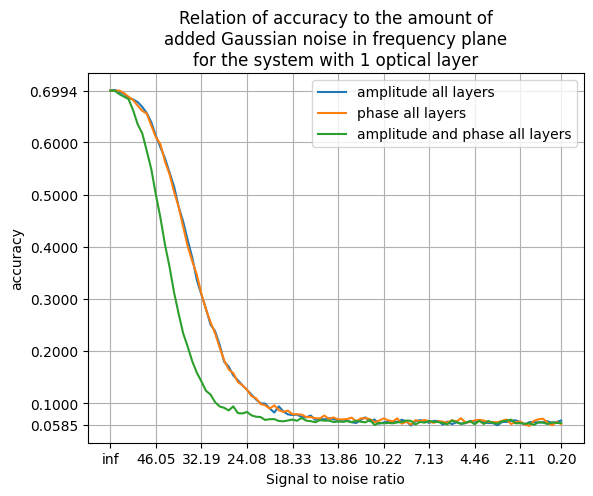

In [30]:
plt.plot(x, y_amp, label='amplitude all layers')
plt.plot(x, y_phase, label='phase all layers')
plt.plot(x, y_ampphase, label='amplitude and phase all layers')
if CONFIG.layers > 1:
    for i in range(CONFIG.layers):
        plt.plot(x, y_layer[i], label=f'amplitude and phase at layer {i}')
plt.xlabel("Signal to noise ratio")
plt.ylabel("accuracy")
plt.title(f"Relation of accuracy to the amount of\nadded Gaussian noise in frequency plane\nfor the system with {CONFIG.layers} optical layer{'s' if CONFIG.layers >1 else ''}")
plt.grid()
plt.legend()
x_label_values = np.concatenate([x[::10], [x[-1]]])
plt.gca().set_xticks(x_label_values, [f"{tt:.2f}" for tt in 20*np.log(1/x_label_values)]);
yticks = np.append(plt.gca().get_yticks()[:-2], [np.array(y_ampphase).min(), np.array(y_ampphase).max()])
plt.gca().set_yticks(yticks[1:]);